In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from typing import Dict, List, Tuple
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D


plt.style.use('default')
sns.set_palette("husl")

plt.rcParams.update({
    'font.size': 11,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})


In [9]:
def load_imputation_data(results_dir='results_output_10_uncertainty_new'):
    summary_file = os.path.join(results_dir, 'imputation_summary.csv')
    summary_df = pd.read_csv(summary_file)
    
    results_file = os.path.join(results_dir, 'mask_and_compare_results.pkl')
    with open(results_file, 'rb') as f:
        detailed_results = pickle.load(f)
    
    return summary_df, detailed_results


,ontology,test_cases,imputation_efficiency_pct,imputation_efficiency_CI_low,imputation_efficiency_CI_high,prediction_score,prediction_score_CI_low,prediction_score_CI_high,shuffle_score,shuffle_score_CI_low,shuffle_score_CI_high,random_score,random_score_CI_low,random_score_CI_high,model_vs_shuffle_diff_pct,model_vs_shuffle_pval,model_vs_random_diff_pct,model_vs_random_pval
0,MF,3864,84.98,83.95,85.99,83.26,82.33,84.20,75.27,74.03,76.46,75.35,73.98,76.67,7.99,0.00,7.91,0.0
1,BP,3000,82.95,81.71,84.14,81.18,80.07,82.30,74.21,72.68,75.76,72.11,70.42,73.75,6.97,0.00,9.07,0.0
2,CC,3867,80.40,79.09,81.67,79.26,77.94,80.53,77.95,76.31,79.60,70.04,67.72,72.26,1.30,0.15,9.21,0.0


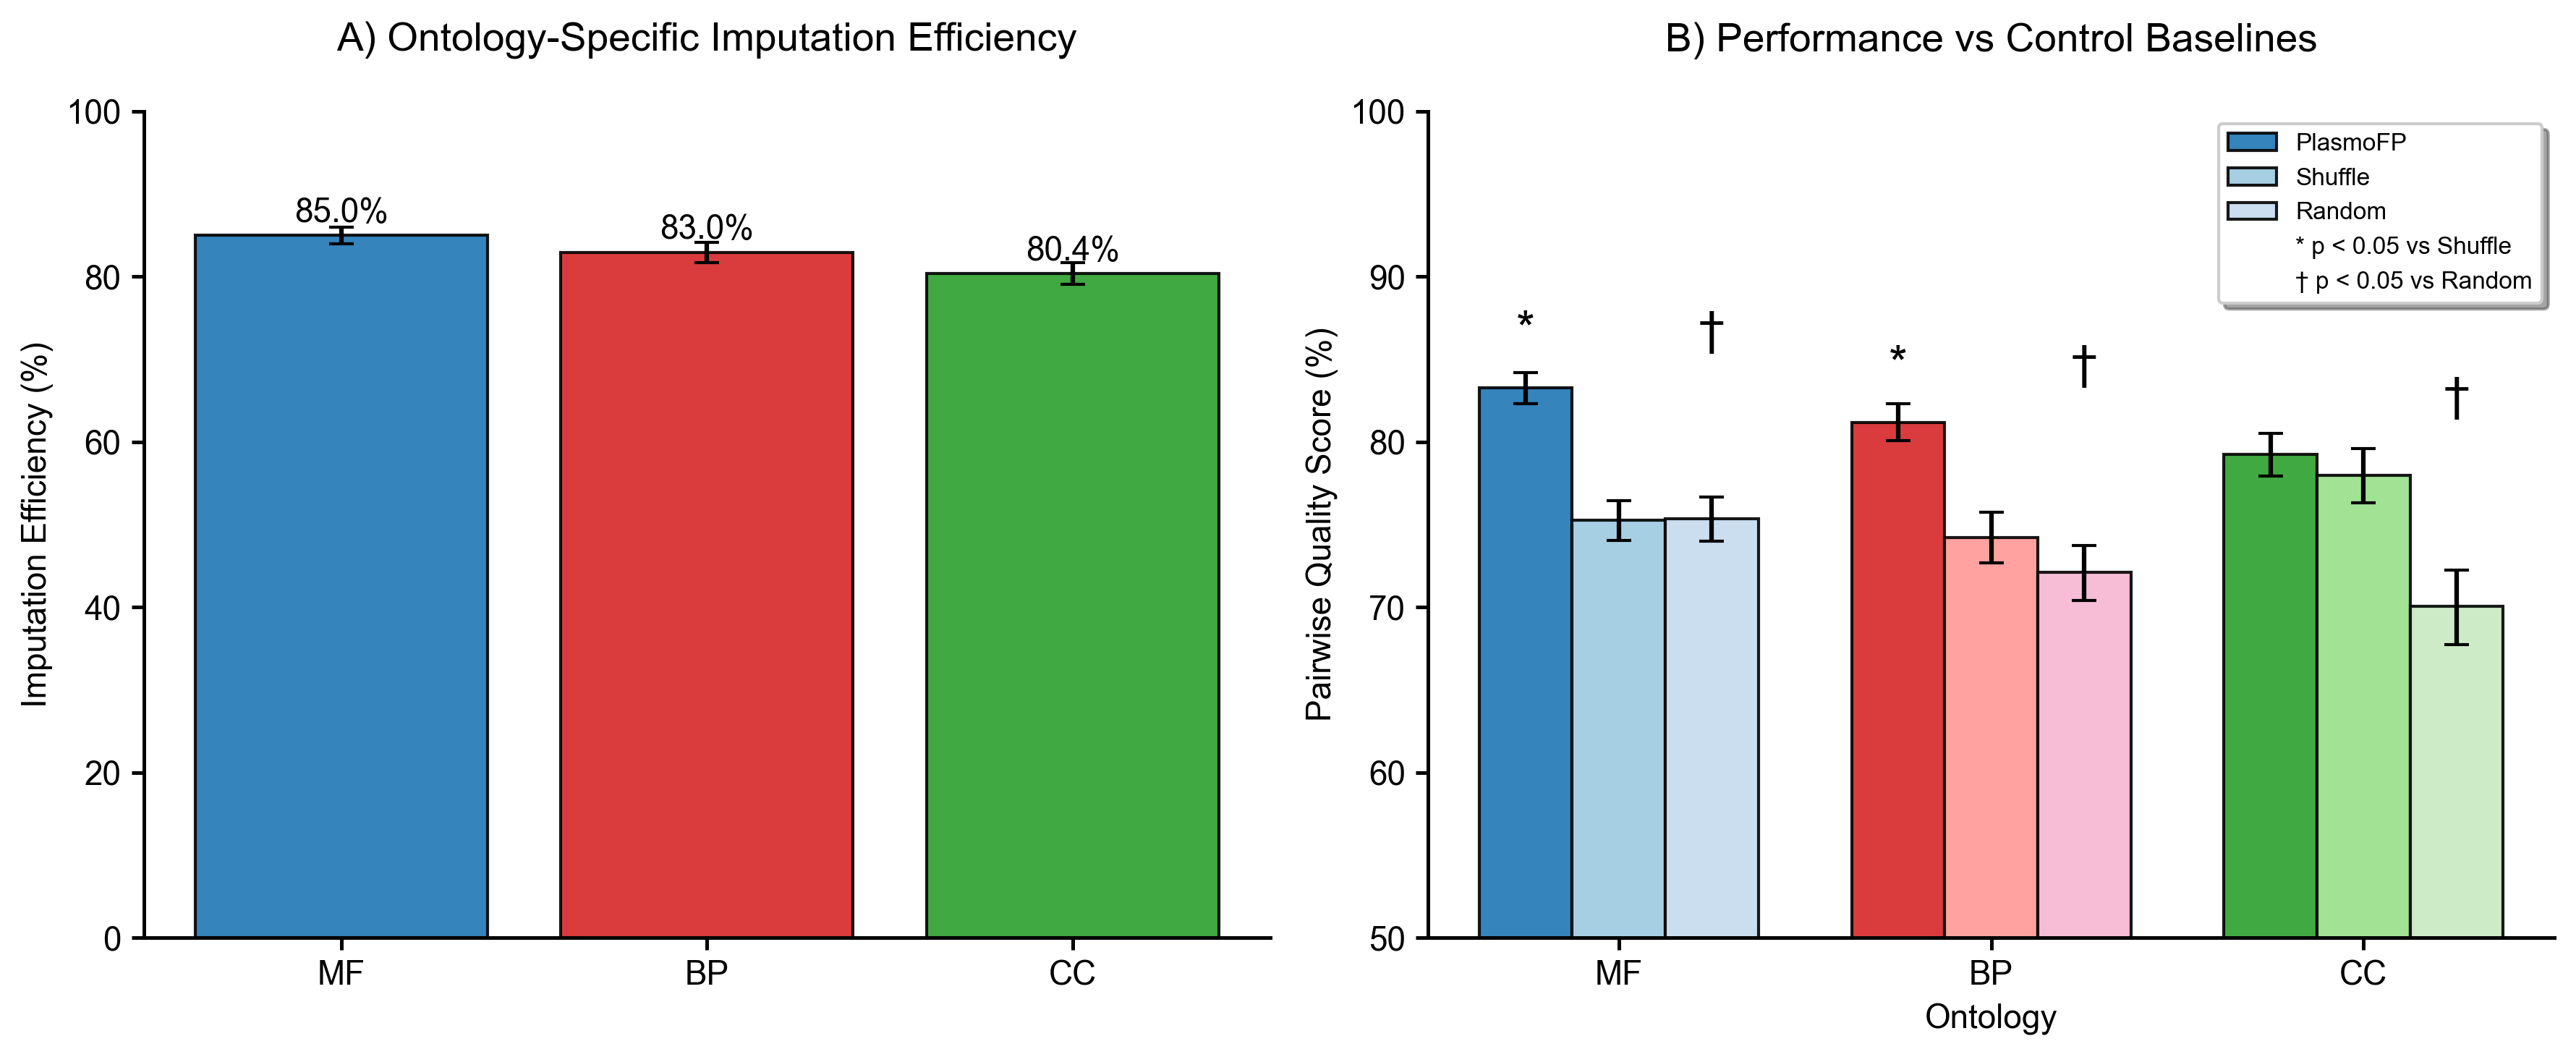

In [10]:
summary_df, detailed_results = load_imputation_data('results_output_20_uncertainty_new')

overall_avg = summary_df['imputation_efficiency_pct'].mean()

# Show table with CIs & p-values
cols_to_show = [
    'ontology', 'test_cases',
    'imputation_efficiency_pct', 'imputation_efficiency_CI_low', 'imputation_efficiency_CI_high',
    'prediction_score', 'prediction_score_CI_low', 'prediction_score_CI_high',
    'shuffle_score', 'shuffle_score_CI_low', 'shuffle_score_CI_high',
    'random_score', 'random_score_CI_low', 'random_score_CI_high',
    'model_vs_shuffle_diff_pct', 'model_vs_shuffle_pval',
    'model_vs_random_diff_pct', 'model_vs_random_pval'
]
display(summary_df[cols_to_show].round(2))

BASE = {'MF': '#1f77b4', 'BP': '#d62728', 'CC': '#2ca02c'}       # blue, red, green
SHUF = {'MF': '#9ecae1', 'BP': '#ff9896', 'CC': '#98df8a'}       # lighter
RAND = {'MF': '#c6dbef', 'BP': '#f7b6d2', 'CC': '#c7e9c0'}       # lightest

ontologies = summary_df['ontology'].values
eff        = summary_df['imputation_efficiency_pct'].values
eff_lo     = summary_df['imputation_efficiency_CI_low'].values
eff_hi     = summary_df['imputation_efficiency_CI_high'].values
eff_err    = np.vstack([eff - eff_lo, eff_hi - eff])

colorsA = [BASE[o] for o in ontologies]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bars1 = ax1.bar(ontologies, eff, yerr=eff_err, color=colorsA, capsize=4,
                alpha=0.9, edgecolor='black', linewidth=1)
for bar, val in zip(bars1, eff):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.8,
             f'{val:.1f}%', ha='center', va='bottom')
ax1.set_ylabel('Imputation Efficiency (%)')
ax1.set_title('A) Ontology-Specific Imputation Efficiency', pad=20)
ax1.set_ylim(0, 100)

x = np.arange(len(ontologies))
width = 0.25

m    = summary_df['prediction_score'].values
m_lo = summary_df['prediction_score_CI_low'].values
m_hi = summary_df['prediction_score_CI_high'].values
m_err = np.vstack([m - m_lo, m_hi - m])

s    = summary_df['shuffle_score'].values
s_lo = summary_df['shuffle_score_CI_low'].values
s_hi = summary_df['shuffle_score_CI_high'].values
s_err = np.vstack([s - s_lo, s_hi - s])

r    = summary_df['random_score'].values
r_lo = summary_df['random_score_CI_low'].values
r_hi = summary_df['random_score_CI_high'].values
r_err = np.vstack([r - r_lo, r_hi - r])

model_colors  = [BASE[o] for o in ontologies]
shuffle_colors = [SHUF[o] for o in ontologies]
random_colors  = [RAND[o] for o in ontologies]

bars2 = ax2.bar(x - width, m, width, yerr=m_err, capsize=4,
                label='PlasmoFP', color=model_colors, alpha=0.9,
                edgecolor='black', linewidth=1)
bars3 = ax2.bar(x, s, width, yerr=s_err, capsize=4,
                label='Shuffle', color=shuffle_colors, alpha=0.9,
                edgecolor='black', linewidth=1)
bars4 = ax2.bar(x + width, r, width, yerr=r_err, capsize=4,
                label='Random', color=random_colors, alpha=0.9,
                edgecolor='black', linewidth=1)

ax2.set_xlabel('Ontology')
ax2.set_ylabel('Pairwise Quality Score (%)')
ax2.set_title('B) Performance vs Control Baselines', pad=20)
ax2.set_xticks(x)
ax2.set_xticklabels(ontologies)
ax2.set_ylim(50, 100)

p_vs_shuf = summary_df['model_vs_shuffle_pval'].values
p_vs_rand = summary_df['model_vs_random_pval'].values
for i, (mi, si, ri, psh, pra) in enumerate(zip(m, s, r, p_vs_shuf, p_vs_rand)):
    if psh < 0.05 and mi > si:
        ax2.text(i - width, mi + 2.0, '*', ha='center', va='bottom', fontsize=16)
    if pra < 0.05 and mi > ri:
        ax2.text(i + width, mi + 2.0, '†', ha='center', va='bottom', fontsize=16)

from matplotlib.lines import Line2D

sig_legend = [
    Line2D([], [], color='none', label='* p < 0.05 vs Shuffle'),
    Line2D([], [], color='none', label='† p < 0.05 vs Random'),
]

ax2.legend(
    handles=[bars2, bars3, bars4, *sig_legend],
    labels=['PlasmoFP', 'Shuffle', 'Random', '* p < 0.05 vs Shuffle', '† p < 0.05 vs Random'],
    frameon=True, fancybox=True, shadow=True, fontsize=8
)


plt.tight_layout()
plt.show()
